Local Peclet number is: 15.625
0.014625 0.001
error_L2  = 0.2791324280707665


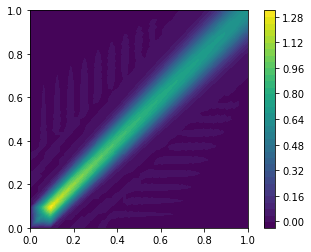

Local Peclet number is: 15.625
0.014625 0.014625
error_L2  = 0.10902557542114176


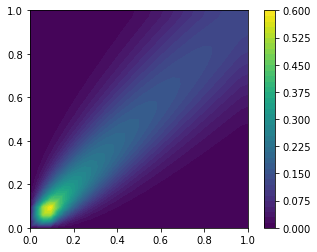

In [56]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt
for i in range(2):
    case = '_usual'
    N = 32
    mu = 0.001
    c1 = 1/np.sqrt(2)
    b = Constant([c1,c1])
    r = Constant(0)
    f = Expression('x[0]< 0.1 && x[1] < 0.1 ? 10 : 0', degree=2)
    frm = np.sqrt(1/2 + 1/2)
    pe = frm*1/(N * 2 * mu)
    print('Local Peclet number is:', pe)
    sigma = 1/(frm*2 * N)*(1/np.tanh(pe) -1/pe)
    if i == 1:
        case = "_supg"
        mu = max(sigma, mu)
    print(sigma, mu)
    # Create mesh and define function space
    mesh = UnitSquareMesh(N, N)

    V = FunctionSpace(mesh, "P", 1)

    # Define boundary condition
    import sympy as sym 
    u_D = Constant(0)
    
    mu = Constant(mu)
    
    
    u_00 = Constant(0)                         # restrict to x = 0
    u_10 = Constant(0)                         # restrict to x = 1
    g_01 = Constant(0)       
    g_11 = Constant(0)             #Neumann bcs
    

    # Define boundary conditions
    boundary_conditions = {0: {'Dirichlet': u_00},   # x = 0
                            1: {'Neumann': g_01},   # x = 1
                            2: {'Dirichlet':   u_10}, # y = 0
                            3: {'Neumann':   g_11}}      # y = 1  
    
    tol = 1e-14

    class BoundaryX0(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], 0, tol)

    class BoundaryX1(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], 1, tol)

    class BoundaryY0(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[1], 0, tol)

    class BoundaryY1(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[1], 1, tol)

    # Mark boundaries
    boundary_markers = MeshFunction('size_t', mesh, mesh.topology().dim() - 1) 
    boundary_markers.set_all(9999)
    bx0 = BoundaryX0()
    bx1 = BoundaryX1()
    by0 = BoundaryY0()
    by1 = BoundaryY1()
    bx0.mark(boundary_markers, 0)
    bx1.mark(boundary_markers, 1)
    by0.mark(boundary_markers, 2)
    by1.mark(boundary_markers, 3)

    # Redefine boundary integration measure
    ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)

    # Collect Dirichlet conditions
    bcs = []
    for i in boundary_conditions:
        if 'Dirichlet' in boundary_conditions[i]:
            bc = DirichletBC(V, boundary_conditions[i]['Dirichlet'],
                             boundary_markers, i)
            bcs.append(bc)
    u = TrialFunction(V)
    v = TestFunction(V)
    # Collect Neumann integrals
    integrals_N = []
    for i in boundary_conditions:
        if 'Neumann' in boundary_conditions[i]:
            if boundary_conditions[i]['Neumann'] != 0:
                g = boundary_conditions[i]['Neumann']
                integrals_N.append(g*v*ds(i))
    
    
    # Define variational problem

    a = mu * dot(grad(u), grad(v))*dx + r*u*v*dx + dot(b,grad(u))*v*dx
    L = f*v*dx + sum(integrals_N)

    # Compute solution
    u = Function(V)
    solve(a == L, u, bcs)
    plt.show()
    # Plot solution and mesh
    c = plot(u)
    plt.colorbar(c)
    #plot(mesh)
    # Save solution to file in VTK format
    vtkfile = File('adr_r_n/solution_comp'+case+'.pvd')
    vtkfile << u
    

    # Compute error in L2 norm
    error_L2 = errornorm(u_D, u, 'L2', degree_rise = 4)

    print('error_L2  =', error_L2)

    # Hold plot
    plt.show()
